## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import pytz
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import helper
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


### Header

In [2]:
try:
    theme = TerminalStyle("dark", "dark", "dark")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

user_time_zone = pytz.timezone(helper.get_user_timezone())

In [3]:
author = "Diogo Sousa"
report_title = f"Global economy report"
report_date = pd.Timestamp.now(tz=user_time_zone).strftime("%d %B, %Y")
report_time = pd.Timestamp.now(tz=user_time_zone).strftime("%H:%M")
report_timezone = pd.Timestamp.now(tz=user_time_zone).tzinfo
report_name = "economy_test"
report_title, report_date, report_time, report_timezone

('Global economy report',
 '29 August, 2022',
 '16:34',
 <DstTzInfo 'Portugal' WEST+1:00:00 DST>)

## Data

Overview

In [4]:
overview = openbb.economy.overview()
overview.set_index(list(overview.columns[0]), inplace = True)
futures = openbb.economy.futures()
futures.set_index(list(futures.columns[0]), inplace = True)
news = openbb.common.news("economy")
news.columns = news.columns.str.title()
news.set_index("Published", inplace = True)

Events

In [5]:
us_week, us_title = openbb.economy.events(country="United states", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="high")
us_week = us_week.set_index("Date")

ez_week, ez_title = openbb.economy.events(country="Euro zone", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="all")
ez_week = ez_week[(ez_week["Importance"]=="High") | (ez_week["Importance"]=="Medium")]
ez_week = ez_week.set_index("Date")

cn_week, cn_title = openbb.economy.events(country="China", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="all")
cn_week = cn_week.set_index("Date")

Yields

Expected list of 3 axis items


Expected list of 3 axis items.

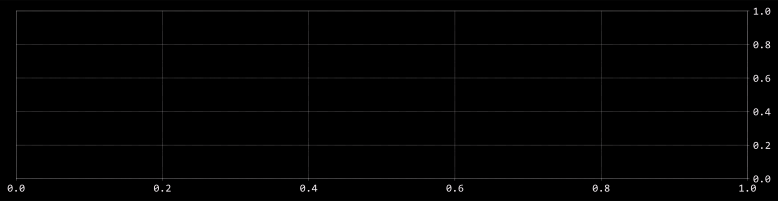

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(11, 3), dpi=150)
country="Germany"
ycrv_data = openbb.economy.ycrv(country=country)

openbb.economy.ycrv(country=country, external_axes=[ax1, ax2], chart=True)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ycrv_chart = f.getvalue().decode("utf-8")

ycrv_data.drop(["Tenor"], axis=1, inplace=True)
# ycrv_data.index = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]
ycrv_data.index.name = "Tenor"

In [7]:
openbb.economy.treasury_maturities()

,Maturities
Instrument,
nominal,"1m, 3m, 6m, 1y, 2y, 3y, 5y, 7y, 10y, 20y, 30y"
inflation,"5y, 7y, 10y, 20y, 30y"
average,Defined by function
secondary,"4w, 3m, 6m, 1y"


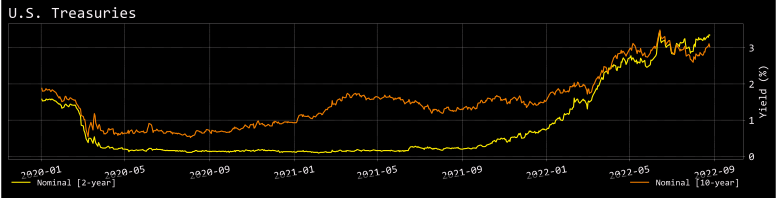

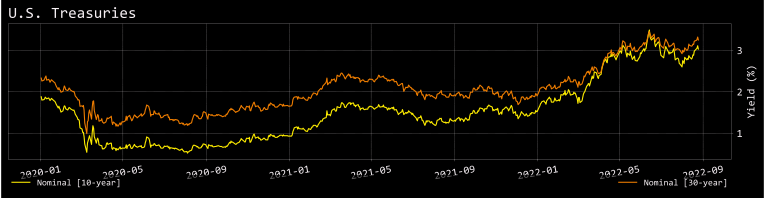

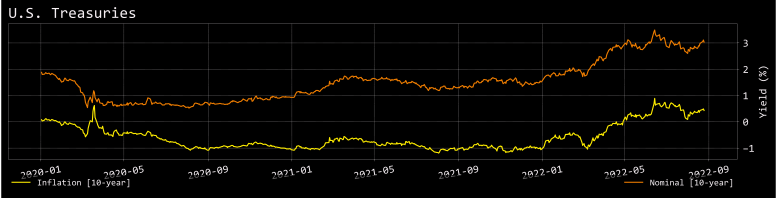

In [8]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.treasury(instruments=["nominal"], maturities=["2y", "10y"], frequency="daily", start_date="2020-01-01", external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
twos_tens = f.getvalue().decode("utf-8")

fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.treasury(instruments=["nominal"], maturities=["10y", "30y"], frequency="daily", start_date="2020-01-01", external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
tens_thirties = f.getvalue().decode("utf-8")

fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.treasury(instruments=["nominal", "inflation"], maturities=["10y"], frequency="daily", start_date="2020-01-01", external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
nominal_tips_tens = f.getvalue().decode("utf-8")

Sectors

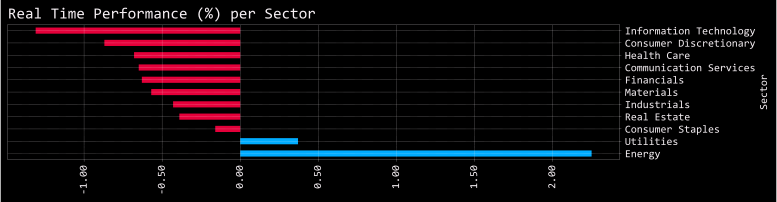

In [9]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.rtps(external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
rtps_chart = f.getvalue().decode("utf-8")
rtps_data = openbb.economy.rtps()

valuation = openbb.economy.valuation()
performance = openbb.economy.performance()

Macro

In [10]:
openbb.economy.country_codes()

,Country,Code
0,Vietnam,VNM
1,Argentina,ARG
2,Australia,AUS
3,Brazil,BRA
4,Britain,GBR
5,Canada,CAN
6,Chile,CHL
7,China,CHN
8,Colombia,COL
9,Costa Rica,CRI


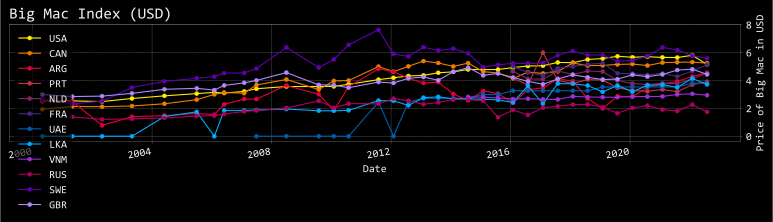

In [11]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.bigmac(country_codes=["USA", "CAN", "ARG", "PRT", "NLD", "FRA", "UAE", "LKA", "VNM", "RUS", "SWE", "GBR"], external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bigmac = f.getvalue().decode("utf-8")

## Render the report template to a file

In [12]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
body += widgets.header(
    img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>GLOBAL ECONOMY REPORT:</b>",
)

body += widgets.tablinks(
    [
        "Overview",
        "Events",
        "Yields",
        "Sectors",
        "Macro",
    ]
)

# Overview
htmlcode = widgets.row([widgets.h(3, "Global markets") + overview.to_html()])
htmlcode += widgets.row([widgets.h(3, "Commodities") + futures.to_html()])
htmlcode += widgets.row([widgets.h(3, "Top news on 'economy'") + news[:6].to_html()])
body += widgets.add_tab("Overview", htmlcode)

# Events
htmlcode = widgets.row([widgets.h(3, us_title) + us_week.to_html()])
htmlcode += widgets.row([widgets.h(3, ez_title) + ez_week.to_html()])
htmlcode += widgets.row([widgets.h(3, cn_title) + cn_week.to_html()])
body += widgets.add_tab("Events", htmlcode)

# Yields
htmlcode = widgets.row([widgets.h(3, "US Yield curve") + ycrv_chart])
htmlcode += widgets.row([widgets.h(3, "") + ycrv_data.to_html()])
htmlcode += widgets.row([widgets.h(3, "2Y-10Y UST") + twos_tens])
htmlcode += widgets.row([widgets.h(3, "10Y-30Y UST") + tens_thirties])
htmlcode += widgets.row([widgets.h(3, "Nominal vs TIPS 10Y UST") + nominal_tips_tens])

body += widgets.add_tab("Yields", htmlcode)

# Sectors
htmlcode = widgets.row([widgets.h(3, "Real-time sector performance") + rtps_chart])
htmlcode += widgets.row([widgets.h(3, "") + rtps_data.to_html()])
htmlcode += widgets.row([widgets.h(3, "Valuation") + valuation.to_html()])
htmlcode += widgets.row([widgets.h(3, "Performance") + valuation.to_html()])
body += widgets.add_tab("Sectors", htmlcode)

# Macro
htmlcode = widgets.row([widgets.h(3, "Bigmac index") + bigmac])
body += widgets.add_tab("Macro", htmlcode)

body += widgets.tab_clickable_evt()
report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)